In [ ]:
#importing libraries
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
import datetime as dt

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

In [ ]:
df=pd.read_excel("Homes for Sale and Real Estate.xlsx")
df

,Address,Price,Description,Place,Beds,Bath,Sq.Ft,Website
0,3704 42 St SW,979999,CA AB T3E 3N1,Glenbrook,4,3.5,1813,Century 21 Bravo Realty
1,30 Mahogany Mews SE #415,439900,CA AB T3M 3H4,Mahogany,2,2.0,1029,Century 21 Bamber Realty Ltd.
2,273 Auburn Shores Way SE,950000,CA AB T3M 2E9,Auburn Bay,4,2.5,2545,Exp Realty
3,235 15 Ave SW #404,280000,CA AB T2R 0P6,Beltline,2,2.0,898,RE/MAX Realty Professionals
4,24 Hemlock Crescent SW #2308,649000,CA AB T3C 2Z1,Spruce Cliff,2,2.0,1482,Charles
...,...,...,...,...,...,...,...,...
3355,203 17 Ave NE,799000,CA AB T2E 1L9,Tuxedo Park,3,2.0,869,RE/MAX Real Estate (Central)
3356,4111 162 Ave SW,8000000,CA AB T2Y 0N7,NaN,5,4.5,9031,Diamond Realty & Associates Ltd.
3357,289 Sage Hill Circle NW,595000,CA AB T3R 1V2,Sage Hill,3,2.5,1733,RE/MAX House Of Real Estate
3358,738 1 Ave SW #1307,7988000,CA AB T2P 5G8,Eau Claire,2,2.5,3544,RE/MAX Real Estate (Central)


In [ ]:
df['Price'].fillna('unknown', inplace=True)
df['Website'].fillna('unknown', inplace=True)

In [ ]:
def convert_address(row):
    address = row['Address']
    if 'unknown' not in address.lower():
        # Split address into components
        components = address.split(',')
        # Remove leading/trailing spaces from each component
        components = [comp.strip() for comp in components]
        # Re-arrange components if necessary
        if len(components) == 3:  # Assuming a simple street, city, state format
            street = components[0]
            city = components[1]
            state = components[2]
            return f"{street}, {city}, {state}"
        elif len(components) == 4:  # Assuming street, city, state, and postal code
            street = components[0]
            city = components[1]
            state = components[2]
            postal_code = components[3]
            return f"{street}, {city}, {state}, {postal_code}"
        else:
            return np.nan  # Return NaN for unknown formats
    else:
        return np.nan  # Return NaN if address is unknown

# Assuming df is your DataFrame and 'address' is the column name for addresses
df['formatted_address'] = df.apply(lambda x: convert_address(x), axis=1)

<ipython-input-33-dec22850f15b>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Bath', data=df, palette='GnBu')


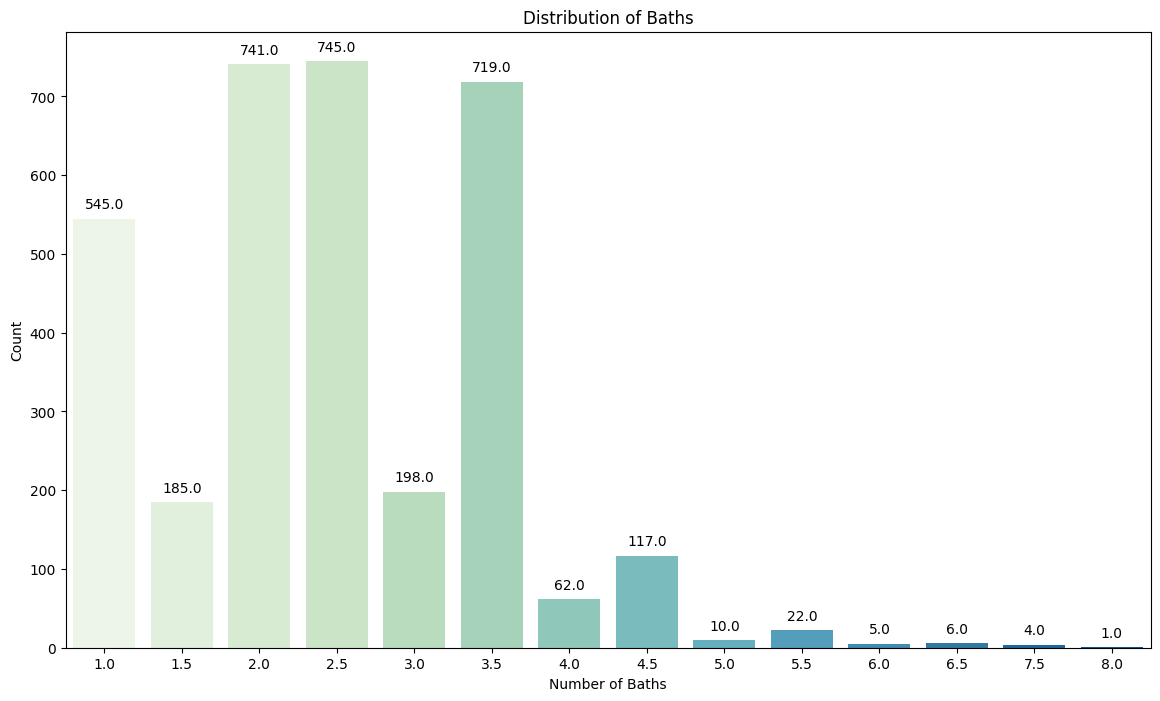

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))
ax = sns.countplot(x='Bath', data=df, palette='GnBu')

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Baths')
plt.xlabel('Number of Baths')
plt.ylabel('Count')

plt.show()


<ipython-input-6-ee41910adda8>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Sq.Ft', x='id', data=top_sqft, palette='icefire')


Top 20 Square Footage Values: ['837', '845', '1086', '1133', '1056', '850', '1600', '951', '905', '1078', '1076', '802', '948', '1100', '864', '500', '960', '1952', '885', '1741']


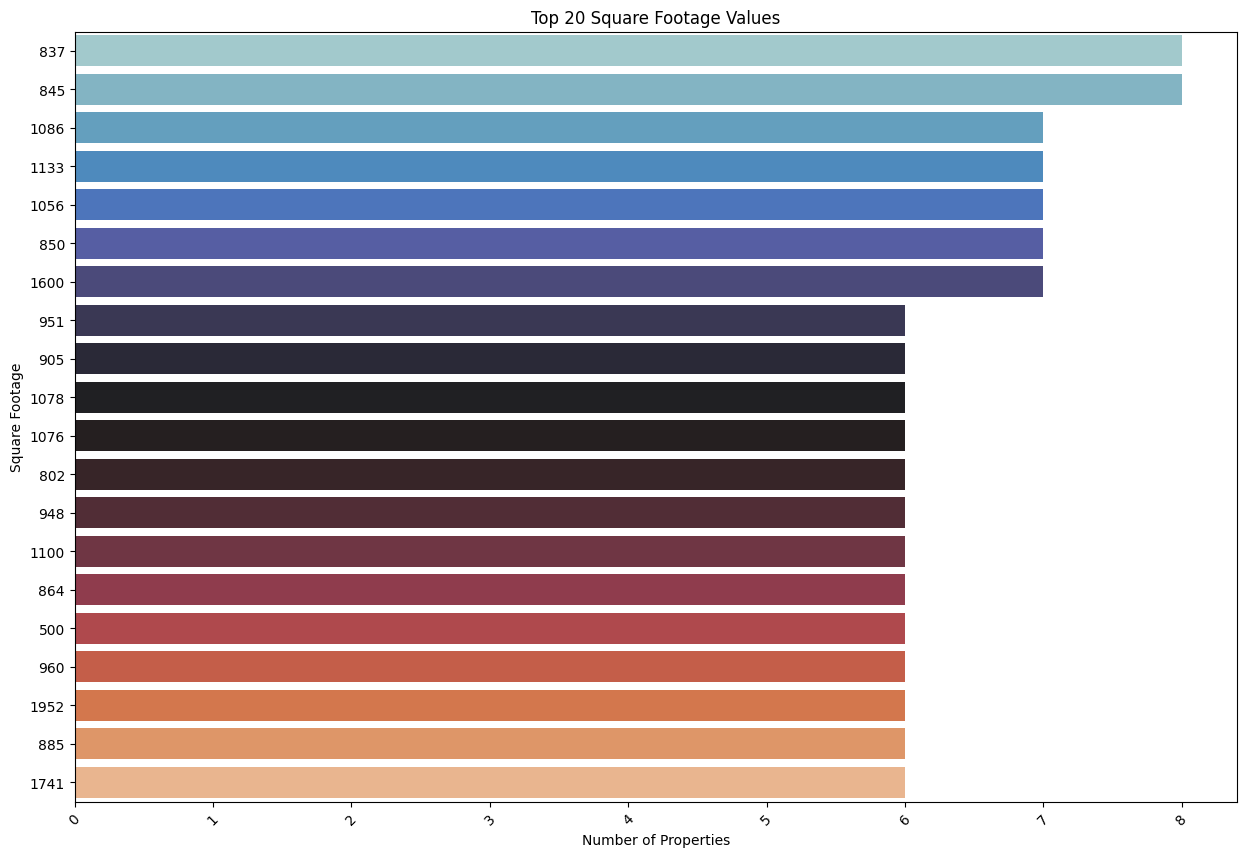

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter DataFrame (assuming 'Sq.Ft' might have non-numeric values)
a = df[df['Sq.Ft'].notna()].loc[:, ['Address', 'Sq.Ft', 'Beds', 'Website']].copy()

# Handle potential non-numeric values in 'Sq.Ft' (assuming they can be coerced)
try:
  a['Sq.Ft'] = pd.to_numeric(a['Sq.Ft'], errors='coerce')  # Convert to numeric, handle errors with 'coerce'
except:
  print("Error converting some Sq.Ft values to numeric. Check data formatting for these entries.")
  print("Problematic values:", a['Sq.Ft'][pd.to_numeric(a['Sq.Ft'], errors='coerce').isnull()])

# Split square footage
sqft_list = a['Sq.Ft'].astype(str).str.split().str[0].tolist()  # Added .astype(str)

# Create DataFrame, group by sqft, count occurrences, sort, select top 20
sqft_count = pd.DataFrame({'Sq.Ft': sqft_list, 'id': range(len(sqft_list))})
top_sqft = (sqft_count.groupby('Sq.Ft')
            .agg({'id': 'count'})
            .sort_values('id', ascending=False)
            .head(20)
            .reset_index())

# Create bar plot with customization
plt.figure(figsize=(15, 10))
sns.barplot(y='Sq.Ft', x='id', data=top_sqft, palette='icefire')
plt.title('Top 20 Square Footage Values')
plt.ylabel('Square Footage')
plt.xlabel('Number of Properties')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Extract top 20 sqft values (optional)
top_20_sqft = top_sqft['Sq.Ft'].tolist()
print("Top 20 Square Footage Values:", top_20_sqft)

plt.show()  # Display the plot


<ipython-input-48-d64b143a1649>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Sq.Ft', x='id', data=top_sqft, palette='icefire')


Top 20 Square Footage Values: ['1029', '1482', '1813', '2545', '898']


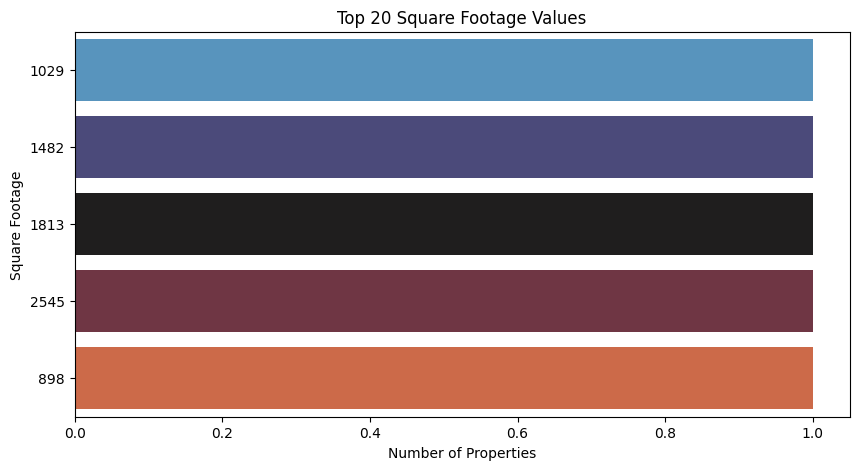

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows with 'unknown' square footage and select relevant columns
a = df[df['Sq.Ft'] != 'unknown'].loc[:, ['Address', 'Sq.Ft', 'Beds', 'Website']].copy()

# Convert 'Sq.Ft' column to string type
a['Sq.Ft'] = a['Sq.Ft'].astype(str)

# Split square footage values with commas and flatten the list
sqft_list = a['Sq.Ft'].str.split(', ').explode().tolist()

# Create a DataFrame to count occurrences of each square footage value
sqft_count = pd.DataFrame({'Sq.Ft': sqft_list, 'id': range(len(sqft_list))})

# Group by square footage and count occurrences, then select top 20 square footage values
top_sqft = sqft_count.groupby('Sq.Ft').agg({'id': 'count'}).sort_values('id', ascending=False).head(20).reset_index()

# Plot the bar plot
plt.figure(figsize=(10, 5))
sns.barplot(y='Sq.Ft', x='id', data=top_sqft, palette='icefire')
plt.title('Top 20 Square Footage Values')
plt.ylabel('Square Footage')
plt.xlabel('Number of Properties')

# If you want to extract the top 20 square footage values for further analysis, you can do it like this:
top_20_sqft = top_sqft['Sq.Ft'].tolist()
print("Top 20 Square Footage Values:", top_20_sqft)


<ipython-input-29-a4d9e9360590>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Beds', x='id', data=top_beds, palette='copper')


Top 10 Numbers of Bedrooms: ['2', '4', '3', '1', '5', '6', '7', '8', '10']


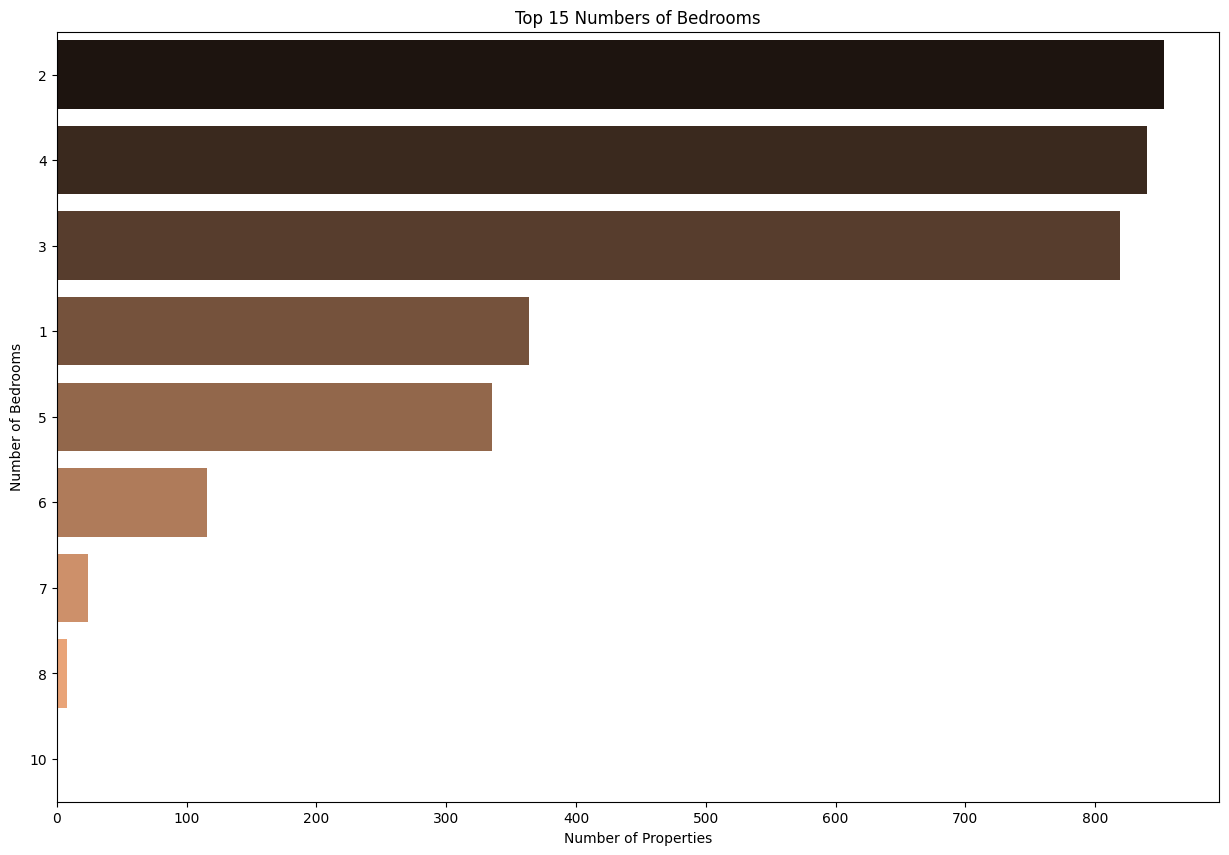

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows with 'unknown' beds
a = df[df['Beds'] != 'unknown'].loc[:, ['Address', 'Price', 'Beds', 'Website']].copy()

# Extract the 'Beds' column
beds_list = a['Beds'].tolist()

new_list = []
for beds in beds_list:
    # Convert integer to string for compatibility
    beds_str = str(beds)
    if ',' in beds_str:
        parts = beds_str.split(', ')
        new_list.extend(parts)
    else:
        new_list.append(beds_str)

# Create a DataFrame to count occurrences of each number of beds
beds_count = pd.DataFrame({'Beds': new_list, 'id': range(len(new_list))})

# Group by number of beds and count occurrences, then select top 15
top_beds = beds_count.groupby('Beds').agg({'id': 'count'}).sort_values('id', ascending=False).reset_index().head(15)

# Plot the bar plot
plt.figure(figsize=(15, 10))
sns.barplot(y='Beds', x='id', data=top_beds, palette='copper')
plt.title('Top 15 Numbers of Bedrooms')
plt.ylabel('Number of Bedrooms')
plt.xlabel('Number of Properties')
top_10_bedrooms = top_beds.head(10)['Beds'].tolist()
print("Top 10 Numbers of Bedrooms:", top_10_bedrooms)


<ipython-input-31-89f35400f420>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='data_description', x='id', data=top_data_descriptions, palette='bone')


Top 10 Data Descriptions: ['CA  AB T2G 0B5', 'CA  AB T2P 1J3', 'CA  AB T2G 1E5', 'CA  AB T2P 3R8', 'CA  AB T3C 2Z1', 'CA  AB T2G 1H8', 'CA  AB T2R 0H1', 'CA  AB T2E 6J5', 'CA  AB T2X 2B9', 'CA  AB T3A 3H1', 'CA  AB T2P 0X2', 'CA  AB T3M 2L3', 'CA  AB T2G 1L7', 'CA  AB T2V 2W3', 'CA  AB T2X 0X6', 'CA  AB T3A 2E6', 'CA  AB T2G 2L7', 'CA  AB T3N 0V2', 'CA  AB T2G 0T9', 'CA  AB T2R 0B5']


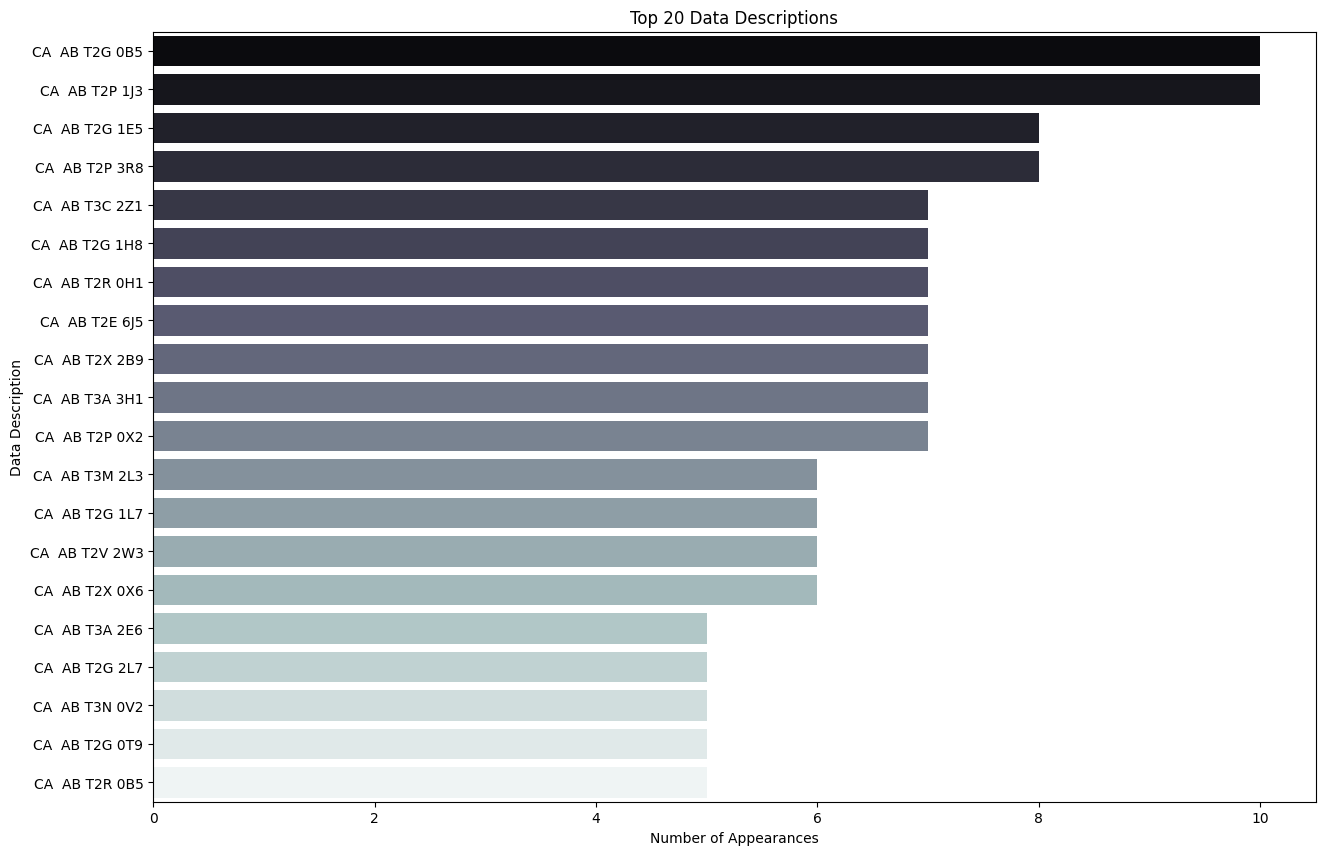

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows with 'unknown' description
a = df[df['Description'] != 'unknown'].loc[:, ['Address', 'Price', 'Description', 'Beds']].copy()

# Extract the 'Description' column
cast = a['Description'].tolist()

newlist = []
for genre in cast:
    if ',' in genre:
        parts = genre.split(', ')
        newlist.extend(parts)
    else:
        newlist.append(genre)

# Create a DataFrame to count occurrences of each data_description
data_description_count = pd.DataFrame({'data_description': newlist, 'id': range(len(newlist))})

# Group by data_description and count occurrences, then select top 20
top_data_descriptions = data_description_count.groupby('data_description').agg({'id': 'count'}).sort_values('id', ascending=False).head(20).reset_index()

# Plot the bar plot
plt.figure(figsize=(15, 10))
sns.barplot(y='data_description', x='id', data=top_data_descriptions, palette='bone')
plt.title('Top 20 Data Descriptions')
plt.ylabel('Data Description')
plt.xlabel('Number of Appearances')
top10_data_descriptions = top_data_descriptions['data_description'].tolist()
print("Top 10 Data Descriptions:", top10_data_descriptions)
